# Iron nanoparticles experiments
November 16, 2023
Experiments by mrlandsman@lbl.gov jmchan@lbl.gov, awojdyla@lbl.gov

This is the very first set of experiments on iron nanoparticles provoided my Jonathan Chan.

The Pilatus deector is about 150 mm from the sample position

We first mesure AgB, and the iron nanoparticles.

This script is the first one from the new experimental campaign, with measurements in vacuum.

We do niot use bluesky -- just epics call through python.

partial log: go.lbl.gov/bl531/log2023

## Setting up the experiment and controls

### import the python packages

In [4]:
#required packages
import epics
import numpy

### Testing EPICS communication

In [5]:
# reading the monochromator angle
epics.caget('bl531_xps1:mono_angle_deg')

26.3

In [ ]:
# mvoing the monochromator if needed
#epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)

In [7]:
# trigerring an acquisition on the pilatus camera
# acquisition settings (filename, exp time, etc. are stored in the IOC)
epics.caput('13PIL1:cam1:Acquire',1)

1

### Reading an image from the camera
after it has been stored on the shared drive (bl531data.lbl.gov), mounted as `/mnt/pilatus/`

In [8]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/sample_20231116_041.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))


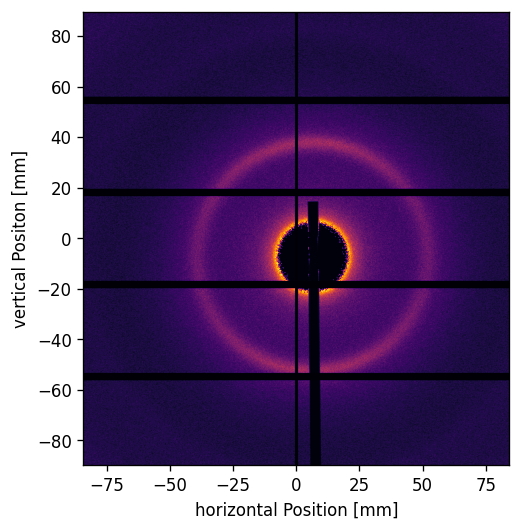

In [132]:
# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

### Creating a script to translate photon energy in monochromator angle
the calibration may be slightly off from a changed M1 angle -- `mono_offset_deg = 12.787`

In [10]:
#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg
mono_deg(7000)

29.195768993164748

## Acquiring images through an energy scan
AgB particles measured near the Cu K-edge (~9kev)

In [16]:
from time import sleep as time_sleep
# there's no settling time in EPICS so we use `sleep` to enforce a guard time after motion

Es_eV = np.linspace(9000, 9100, 11)
for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    #print(mono_angle_deg)
    time_sleep(5)
    epics.caput('13PIL1:cam1:Acquire',1)

25.479182679068188
25.464861275713403
25.450572429683042
25.436316029129856
25.42209196272278
25.407900119643905
25.393740389585496
25.379612662747057
25.365516829832387
25.351452782046636
25.337420411093444


## Matt for loop progress

In [32]:
import pyFAI

In [68]:
#poni = 'poni_version: 2' + '\n' + 'Detector: Pilatus 1M' + '\n' + 'Distance: 0.15' + '\n' + 'Poni1: 0.2' + '\n' + 'Poni2: 0.1' + '\n' + 'Rot1: 0' + '\n' + 'Rot2: 0' + '\n' + 'Rot3: 0' + '\n' + 'Wavelength: 1.2e-10'

poni_file = '/home/bl531/Downloads/20231116_poni_mrl.poni'

azimuthal_integrator = pyFAI.load(poni_file)
#azimuthal_integrator.maskfile = os.path.join( )

In [69]:
file_path = '/mnt/pilatus/'
file_list = sorted(f for f in os.listdir(file_path) if '20231116' in f and '39' not in f)
file_list

['sample_20231116_040.tif',
 'sample_20231116_041.tif',
 'sample_20231116_042.tif',
 'sample_20231116_043.tif',
 'sample_20231116_044.tif',
 'sample_20231116_045.tif',
 'sample_20231116_046.tif',
 'sample_20231116_047.tif',
 'sample_20231116_048.tif',
 'sample_20231116_049.tif',
 'sample_20231116_050.tif',
 'sample_20231116_051.tif',
 'sample_20231116_052.tif']

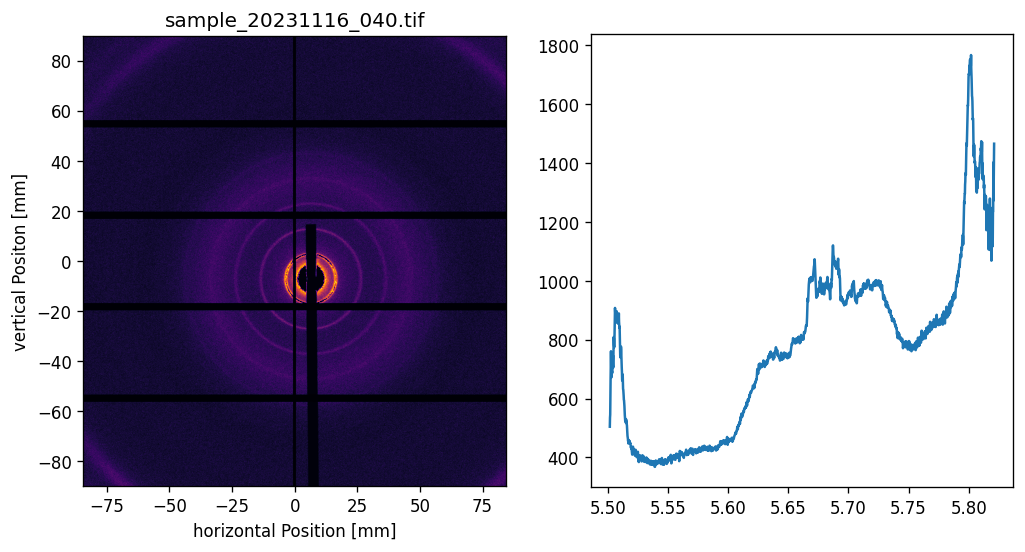

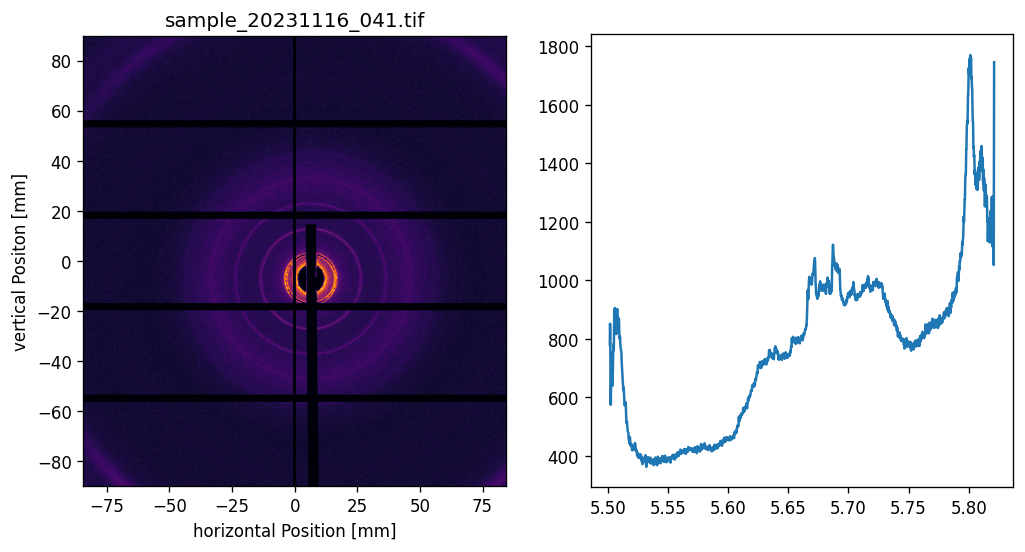

In [70]:
for file in file_list[:2]:
    file_path_mrl = os.path.join(file_path, file)
    im_tiff = Image.open(file_path_mrl)
    im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
    im_np[np.where(im_np>100.0)] =0
    

    dx_m = 172e-6               # pixel size
    Nx_px = 981                 # pixel location for x position of beam center
    Ny_px = 1043                # pixel location for y position of beam center
    Dx_m = Nx_px*dx_m           # horizontal position of beam center
    Dy_m = Ny_px*dx_m           # vertical position of beam center

    fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi= 120, facecolor='w', edgecolor='k')
    extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
    # extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

    mask = im_np > np.max(im_np)
    im_np[mask]=0

    ax[0].imshow(im_np, extent=extent, cmap = 'inferno')
    ax[0].set_xlabel('horizontal Position [mm]')
    ax[0].set_ylabel('vertical Positon [mm]')
    ax[0].set_title(file)
    
    file_reduced = azimuthal_integrator.integrate1d(im_np, npt=2000, azimuth_range = [-180, 180])
    q = file_reduced[0] / 10
    intensity = file_reduced[1] 
    
    ax[1].plot(q, intensity)
    
    # integration is off because the beam position is not accurate and several parameters within the poni file are incorrect --> we can update using the pyFAI-calib2 GUI and an AgB scan 
        
    plt.show()

### Antoine's attempt at an azimuthal sum

Text(0, 0.5, 'image number')

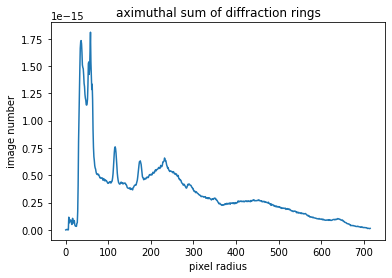

In [89]:
im_warp = warp_polar(im_np, center=[564,526])
plt.plot(np.sum(im_warp,axis=0))
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')

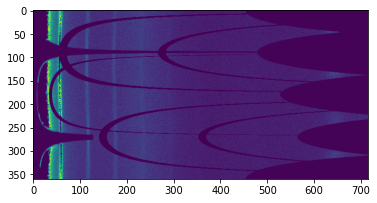

In [87]:
#displaying the azimathal dewarping (for center of been adjustment)
plt.imshow(im_warp)
plt.show()

In [ ]:
## script to scan through

# from skimage.transform import warp, warp_polar
# img_sum = ()
# for image in images:
#     #new_image = image_process_no_log(image)
#     new_image = image
#     im_warp = warp_polar(im_np, center=[526,564])
#     #plt.imshow(im_warp)
#     #plt.show()
#     img_sum += (im_warp,)

## Iron nanoparticles measured at the Fe K-edge

In [122]:
#testing a single acquisition
epics.caput('13PIL1:cam1:Acquire',1)

1

In [133]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/sample_20231116_056.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

/tmp/ipykernel_4080017/2483658895.py:18: RuntimeWarning: invalid value encountered in power
  plt.imshow((im_np)**0.1, extent=extent, cmap = 'jet')


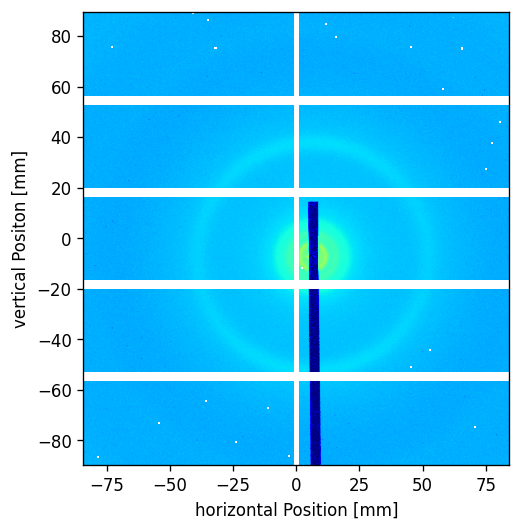

In [136]:
# dealing with dyanmic range
#im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow((im_np)**0.1, extent=extent, cmap = 'jet')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [121]:
# set the mono near the iron K-edge
mono_angle_deg = mono_deg(7100)
epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)

1

In [128]:
import numpy as np
#Es_eV = np.linspace(9000, 9100, 11)
plan = np.genfromtxt('/home/bl531/Downloads/ALSBL5311-XP-20231116a - Sheet2.csv', delimiter=',', skip_header=1)
Es_eV = plan[:,5]


In [129]:
from time import sleep as time_sleep

for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    #print(mono_angle_deg)
    time_sleep(5)
    epics.caput('13PIL1:cam1:Acquire',1)

In [131]:
plan[:,5]

array([7090., 7095., 7100., 7101., 7102., 7103., 7104., 7105., 7106.,
       7107., 7108., 7109., 7110., 7111., 7112., 7113., 7114., 7115.,
       7116., 7117., 7118., 7119., 7120., 7121., 7122., 7123., 7124.,
       7125., 7126., 7127., 7128., 7129., 7130., 7132., 7134., 7136.,
       7138., 7140., 7142., 7144., 7146., 7148., 7150., 7152., 7154.,
       7155., 7160., 7165., 7170., 7090., 7095., 7100., 7105., 7110.,
       7115., 7120., 7125., 7130., 7140., 7150., 7160., 7170.])